## Generate retrospective forecasts using Prophet

Use Prophet to generate retrospective forecasts.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
pd.set_option('precision', 3)
from prophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [29]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily

Set the output path corresponding to the experiment. The ensembling experiment will 
look for specific output files in the output directory corresponding to forecasts, 
e.g.: ./output/prophet_202110/forecasts_2015-07-01.csv
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/prophet_TEST"
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data From File

Be sure to run `load_data.ipynb` to produce the data file `all_data.csv`

In [8]:
foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,1.392,...,3.644,12.051,9.368e+09,9.496e+09,6.749e+09,6.906e+08,1.052e+09,7.479e+08,607.369,605.703
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,1.392,...,1.965,16.745,9.495e+09,9.632e+09,6.881e+09,-9.880e+07,1.539e+08,1.099e+08,605.807,610.678
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,1.392,...,-11.565,1.655,8.803e+09,8.529e+09,6.085e+09,9.138e+08,9.079e+08,6.478e+08,606.799,613.377
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.392,...,13.334,10.821,1.034e+10,9.569e+09,6.897e+09,3.470e+08,6.563e+08,4.730e+08,614.367,619.658
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.377,...,-4.236,6.160,9.598e+09,9.091e+09,6.605e+09,7.013e+08,6.893e+08,5.008e+08,621.915,625.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4,1.203,...,-1.087,31.561,5.159e+10,4.979e+10,4.075e+10,3.661e+09,3.111e+09,2.546e+09,4259.604,4307.137
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8,1.240,...,1.990,18.580,5.106e+10,5.205e+10,4.156e+10,3.780e+08,1.129e+09,9.018e+08,4276.202,4323.730
2021-08-01,158.5,148.3,146.8,165.9,158.0,142.5,182.1,141.7,152.2,1.251,...,-2.312,14.723,5.245e+10,5.115e+10,4.060e+10,1.300e+09,2.674e+09,2.123e+09,4316.303,4337.489
2021-09-01,158.1,148.0,147.1,165.9,158.5,141.5,184.8,144.3,150.0,1.262,...,-3.461,8.557,5.080e+10,4.965e+10,3.920e+10,1.561e+09,2.277e+09,1.798e+09,4346.662,4367.402


## Experiment Setup

In [10]:
report_sim_dates = pd.read_csv("./reportsimdates.txt", sep='\n', header=None)[0].to_list()
report_sim_dates

['2015-07-01',
 '2016-07-01',
 '2017-07-01',
 '2018-07-01',
 '2019-07-01',
 '2020-07-01']

In [11]:
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

In [22]:
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', 'index':'ds', food_category:'y'}, axis=1)
    return df

In [23]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

## Fit and Evaluate Models for All CPI Categories (Validation)

In [24]:
def fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates):
    train_df = get_prophet_df(foodprice_df, food_category, train_dates)     # Select training data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    valid_df = get_prophet_df(foodprice_df, food_category, valid_dates)     # Select the validation data. 
    valid_forecast = model.predict(valid_df[['ds']])                        # Produce the validation period forecast. 

    valid_metrics = {metric_name: metric_fn(y_true=valid_df.y,              # Compute validation metrics. 
                                      y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

    return model, valid_forecast, valid_metrics

In [25]:
def plot_valid_forecast(model, food_category, sim_forecast_date, valid_forecast, valid_actual):

    fig = model.plot(valid_forecast, figsize=(10,4))
    ax = fig.axes[0]
    ax.scatter(valid_actual.ds, valid_actual.y, color='green', s=10, label='Actual CPI')
    ax.set_title(f'CPI Forecast (Simulated From {date}) - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.png", bbox_inches='tight')
    plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.7612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1333.33     0.0573428       705.608           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.38    0.00242738       604.581      0.2152      0.2152      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       1375.98   3.13032e-05       162.578   1.422e-07       0.001      390  LS failed, Hessian reset 
     299          1376   0.000129293       221.946           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1379.44   0.000518229       246.246           1           1      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1381.02   0.000578887     

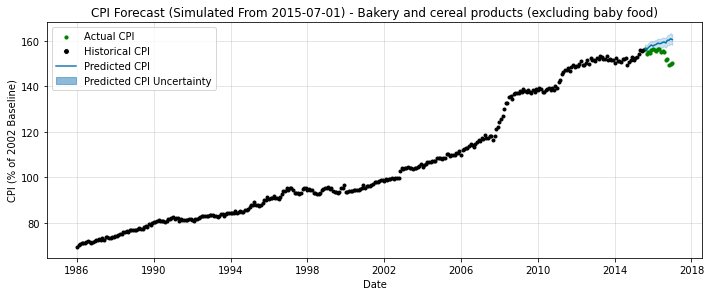

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.430
mae          4.427
mape         0.029
mse         31.380
rmse         5.602
dtype: float64
Initial log joint probability = -2.59973
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1371.64    0.00828718       558.781           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1408.24   0.000283287       181.702           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1412.95    0.00199228       288.353           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          1418    0.00129257       277.447      0.5296      0.5296      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1421.95   0.000988575     

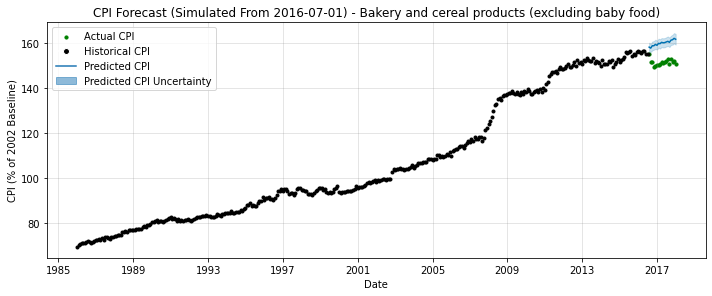

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -44.065
mae          8.589
mape         0.057
mse         76.671
rmse         8.756
dtype: float64
Initial log joint probability = -2.48661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1392.27   0.000634422       382.515      0.2229           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1408.75    0.00756387       1214.78      0.3615      0.3615      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1416.87   0.000453164       177.503      0.3174      0.3174      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1422.13   0.000208382        135.83       0.265       0.265      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1425.52    0.00114169     

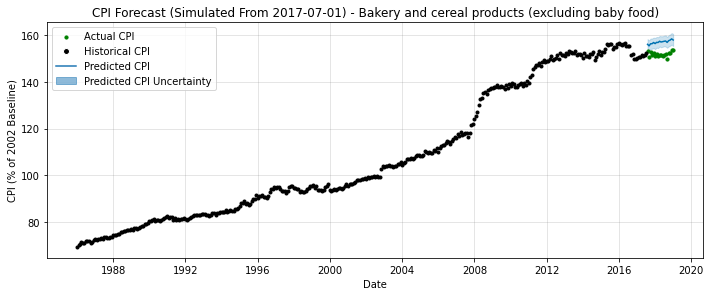

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -25.481
mae          5.141
mape         0.034
mse         27.388
rmse         5.233
dtype: float64
Initial log joint probability = -2.50119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1432.04      0.011595       2052.74           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1459.45   8.69866e-05       293.815      0.3787      0.3787      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.66     0.0197411       493.775           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1490.84   0.000271758       145.311      0.4163      0.4163      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463       1494.72   6.65225e-05     

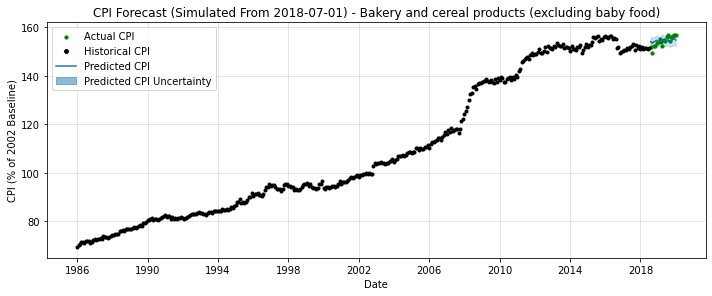

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.278
mae         1.402
mape        0.009
mse         2.881
rmse        1.697
dtype: float64
Initial log joint probability = -2.48641
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1512.39     0.0161865       1791.04           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1534.05    0.00580574       770.436      0.9113      0.9113      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1555.04     0.0061509       699.654           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1558.72   0.000132237       181.016           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     497       1567.39   4.51013e-05       241

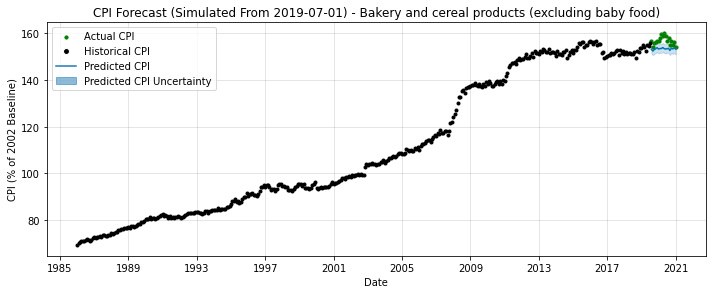

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.494
mae          3.582
mape         0.023
mse         15.057
rmse         3.880
dtype: float64
Initial log joint probability = -2.47511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1558.46   0.000257016       821.307      0.5333      0.5333      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1584.94     0.0180342       650.497      0.9526      0.9526      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1598.11    0.00861711       2648.34      0.1411           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       1602.59   2.36067e-05        131.21   9.421e-08       0.001      408  LS failed, Hessian reset 
     399       1606.61   0.000687109       199.386      0.4079           1      497   
    Iter      log prob

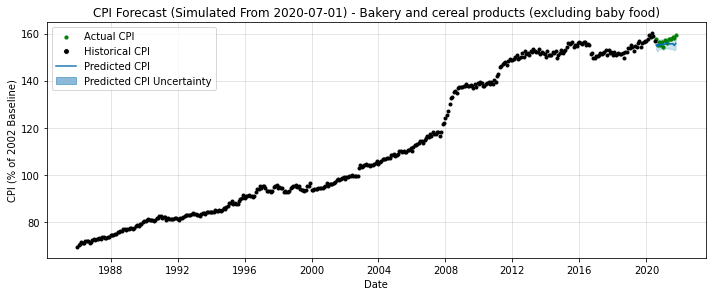

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -1.121
mae         1.658
mape        0.011
mse         3.850
rmse        1.962
dtype: float64
Initial log joint probability = -2.27694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1504.99    0.00794105       3093.37           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1550.42    0.00369973       1969.01      0.6595      0.6595      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1562.68    0.00124822       376.744      0.4715           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1566.17   0.000484895       617.535        0.67        0.67      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1571.35   0.000305362       183

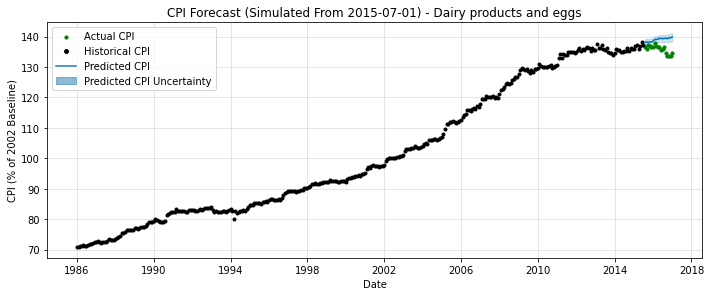

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.667
mae          3.154
mape         0.023
mse         12.906
rmse         3.592
dtype: float64
Initial log joint probability = -2.27357
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1583.69    0.00196873       615.994           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1609.86   0.000397047       1696.45      0.1858      0.1858      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1620.51    0.00210613       1069.54      0.7177      0.7177      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1625.09    0.00563635       770.352           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1627.87     0.0004247     

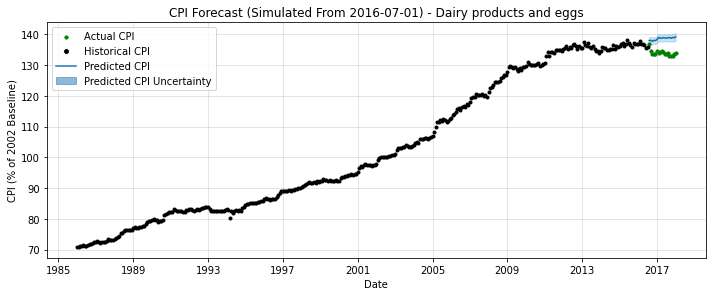

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -29.750
mae          4.619
mape         0.035
mse         22.523
rmse         4.746
dtype: float64
Initial log joint probability = -2.37705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1607.63    0.00178814       1279.25           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1633.45    0.00450187       738.498           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1646.67   0.000394951       327.567           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1657.79     0.0044182        1986.6      0.9131      0.9131      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1662.26   0.000795538     

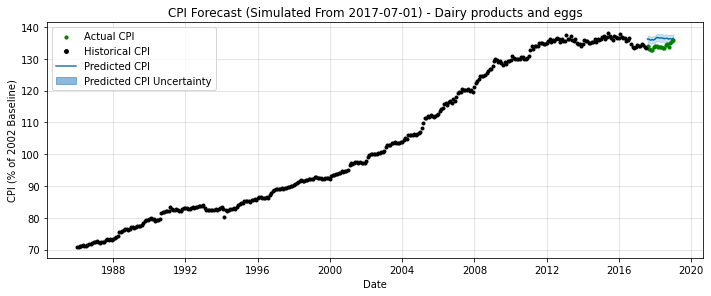

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -7.887
mae         2.371
mape        0.018
mse         6.280
rmse        2.506
dtype: float64
Initial log joint probability = -2.4619
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1666.12     0.0040343       1570.35           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1714.21    0.00565639       1412.54           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1736.11       0.06356       11026.8      0.4872           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          1750   0.000232444       923.099      0.5947      0.5947      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1754.04   0.000217006       209.

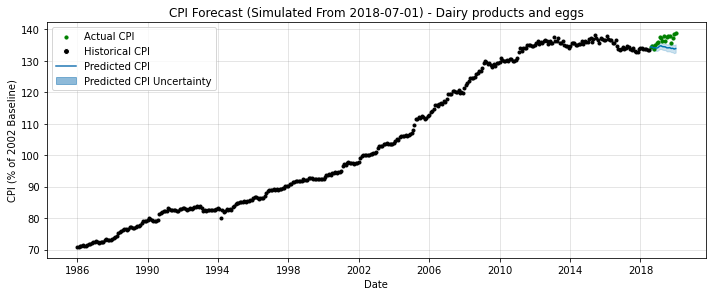

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -2.477
mae         2.364
mape        0.017
mse         7.670
rmse        2.769
dtype: float64
Initial log joint probability = -2.37086
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1733.15    0.00782709        2532.2           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1766.33    0.00147414       753.553           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1775.33   0.000332616       320.737      0.5903      0.5903      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1786.05    0.00482468       1323.41           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1790.11    0.00652197       117

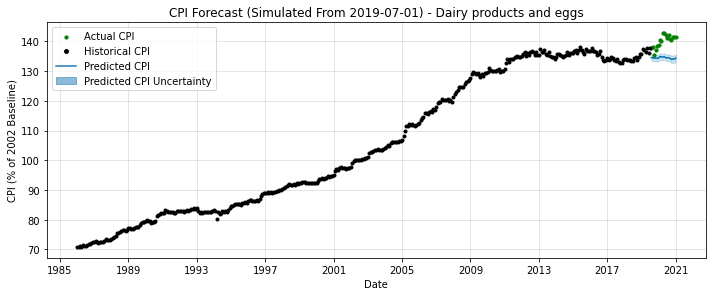

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -7.839
mae          5.754
mape         0.041
mse         37.187
rmse         6.098
dtype: float64
Initial log joint probability = -2.31087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1711.37    0.00457575       469.956       1.329      0.1329      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1735.44   0.000748429       390.719      0.6705      0.6705      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1740.47     0.0024321       410.311           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1743.81    0.00210971       1327.88      0.9687      0.9687      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1746.65   6.27459e-05     

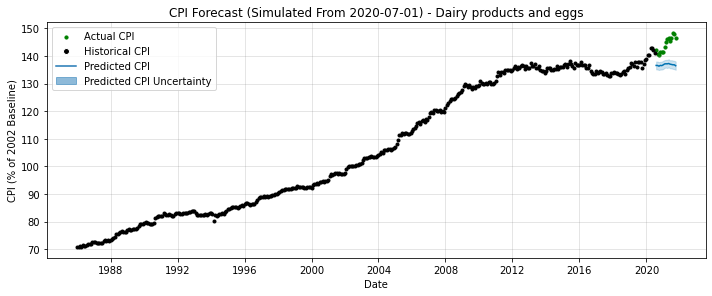

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -7.854
mae          7.421
mape         0.051
mse         61.256
rmse         7.827
dtype: float64
Initial log joint probability = -2.39071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1267.69    0.00287225       346.505           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1284.45    0.00530729       541.652           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1291.01   0.000741314       486.394       0.502       0.502      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1293.65    0.00108986       132.977      0.3312           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1296.05    0.00176214     

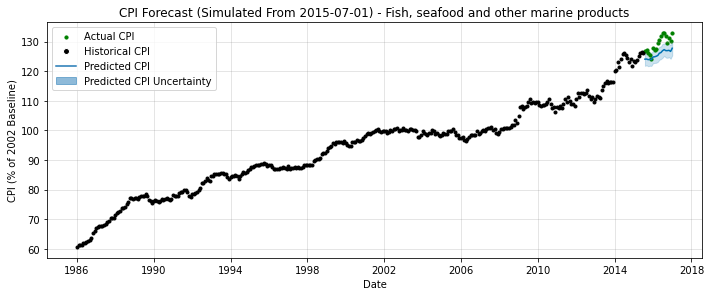

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.041
mae          3.511
mape         0.027
mse         14.679
rmse         3.831
dtype: float64
Initial log joint probability = -2.52016
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1320.65     0.0113398       1165.41           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1349.26     0.0053323       540.243      0.4806      0.4806      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1356.04   0.000683456       131.931      0.3594           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       1359.42   3.52643e-05       103.677   1.603e-07       0.001      466  LS failed, Hessian reset 
     392        1360.2   5.83622e-05       144.316   3.997e-07       0.001      539  LS failed, Hessian reset

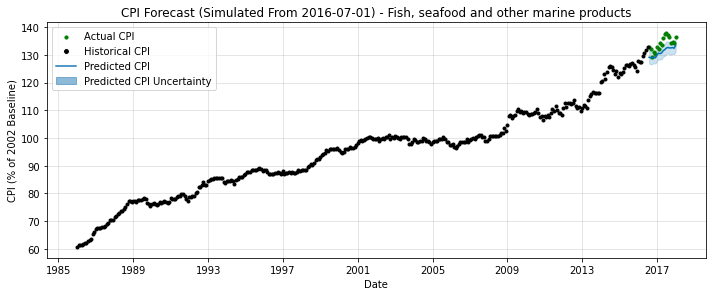

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -0.833
mae          3.015
mape         0.022
mse         11.132
rmse         3.336
dtype: float64
Initial log joint probability = -2.63227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1383.93    0.00230611       454.159      0.9452      0.9452      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1418.15     0.0051415       315.478           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1426.33    0.00664085       1183.54           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       1429.36   3.94214e-05       158.379   3.354e-07       0.001      444  LS failed, Hessian reset 
     399       1432.81   0.000856245       158.833      0.1295           1      510   
    Iter      log prob

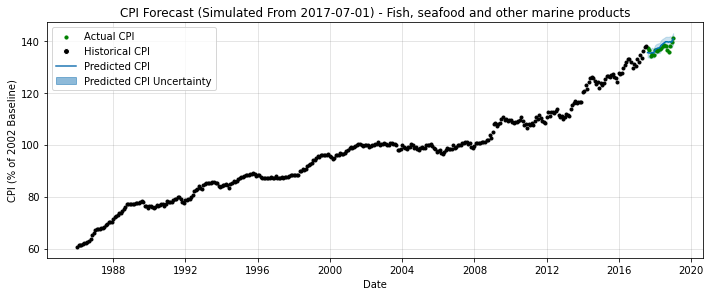

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.165
mae         1.130
mape        0.008
mse         2.251
rmse        1.500
dtype: float64
Initial log joint probability = -2.51039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1454.75     0.0163036       204.306           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1488.02   0.000178528       166.109           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       1503.78   6.37163e-05         292.8   1.894e-07       0.001      335  LS failed, Hessian reset 
     299       1508.99    0.00829575       1337.39           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1512.57    0.00114128       198.346           1           1      484   
    Iter      log prob     

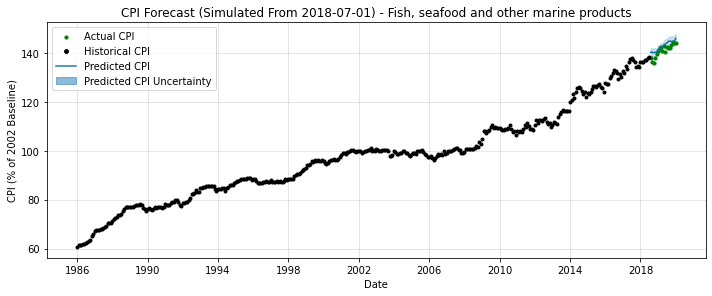

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.285
mae         1.744
mape        0.012
mse         4.689
rmse        2.165
dtype: float64
Initial log joint probability = -2.56655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1515.2     0.0108919        1578.7           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1552.45    0.00269381       203.593           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1568.76     0.0011254       444.511       0.508      0.0508      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1572.43    0.00135195       185.883           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1574.03   0.000231838       546

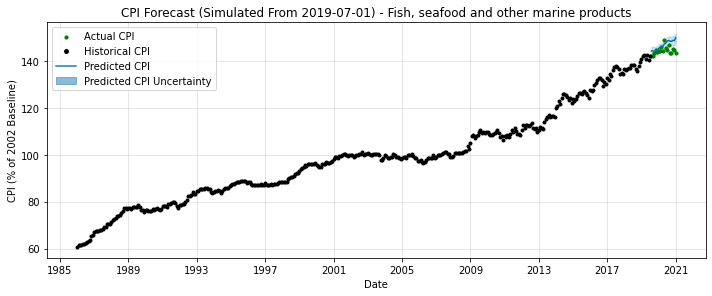

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -2.456
mae         2.436
mape        0.017
mse         9.005
rmse        3.001
dtype: float64
Initial log joint probability = -2.50884
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1570.31    0.00991657       1336.43           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1612.46    0.00107697       307.625           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1623.07     0.0409277       3329.04           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1631.68     0.0015436       633.976      0.4152      0.4152      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     490       1633.13   2.27313e-05       152

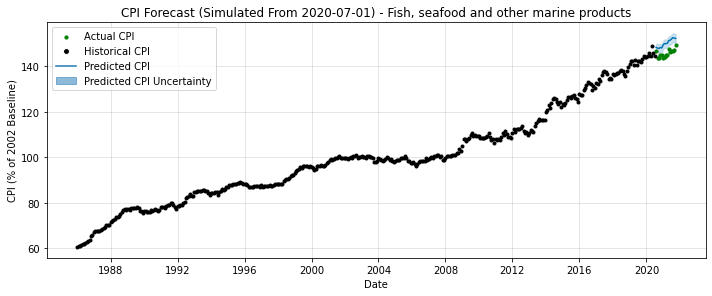

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.540
mae          4.429
mape         0.030
mse         21.220
rmse         4.607
dtype: float64
Initial log joint probability = -2.0862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1640.01   0.000562887       1362.07      0.1577      0.1577      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1714.64   0.000168639       1418.33      0.7162      0.7162      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1750.59    0.00227308       2714.22           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1761.8     0.0111823          2504           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1767.4    0.00106515      

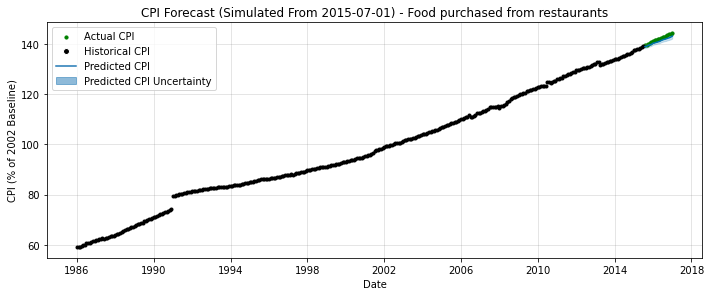

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.554
mae         0.967
mape        0.007
mse         1.014
rmse        1.007
dtype: float64
Initial log joint probability = -2.09869
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1685.17      0.034512       3156.14           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1795.5     0.0170006       695.592           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1809.81    0.00105071       325.505           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1821.91   0.000207344       399.216           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1825.82   0.000936068       427

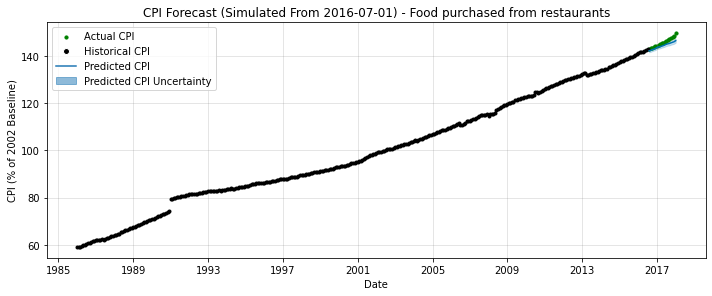

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.302
mae         1.423
mape        0.010
mse         2.439
rmse        1.562
dtype: float64
Initial log joint probability = -2.11409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1766.52     0.0121945       1447.23           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1828.19     0.0018716       2800.33           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1867.46   0.000306896       241.858           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1875.66   0.000521623       713.222      0.4289      0.4289      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1880.79   0.000373359        70

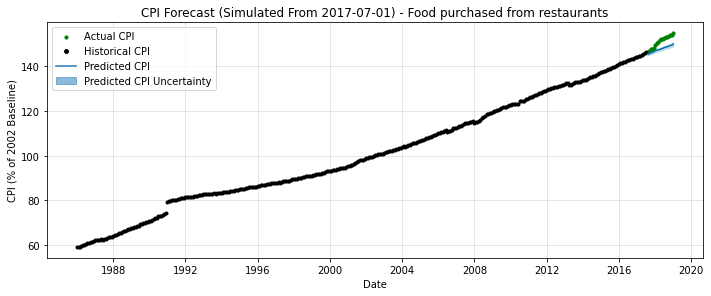

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.009
mae          3.468
mape         0.023
mse         13.898
rmse         3.728
dtype: float64
Initial log joint probability = -2.21958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1754.9    0.00168816       848.425           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1825.1    0.00411882       1161.55           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1858.39    0.00184394       1289.85           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1867.59    0.00243671       2120.72       0.368           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1872.26   0.000433194     

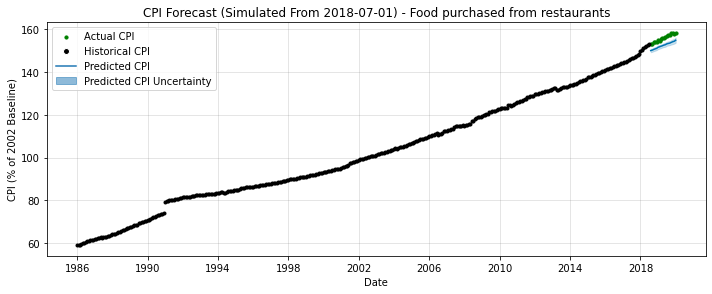

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -3.034
mae          3.449
mape         0.022
mse         12.050
rmse         3.471
dtype: float64
Initial log joint probability = -2.25413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1833.9    0.00820476       1071.99      0.6546      0.6546      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1872.99   0.000318441       387.274           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1895.42   8.57348e-05       304.379           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1898.84    0.00243824       871.133       3.706      0.3706      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1910.82   6.14817e-05     

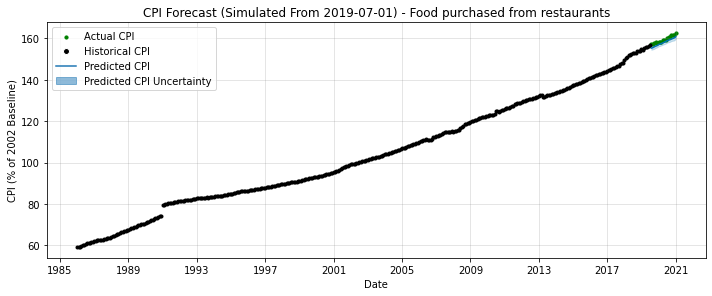

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.135
mae         1.455
mape        0.009
mse         2.265
rmse        1.505
dtype: float64
Initial log joint probability = -2.25978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1899.21    0.00106834       5998.23     0.02399           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1974.79    0.00491456       2178.04           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1997.29    0.00133884       606.733      0.7135      0.7135      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2019.3   0.000427577       623.678           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2027.3    0.00235814       234

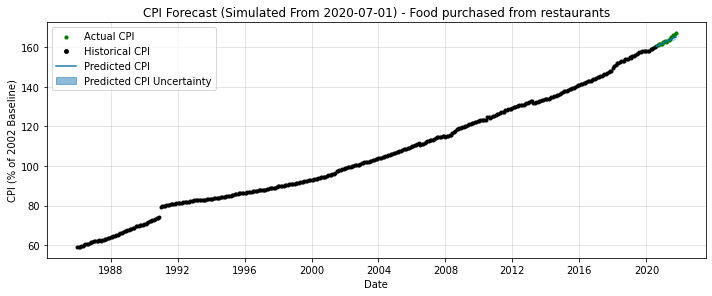

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.842
mae         0.517
mape        0.003
mse         0.574
rmse        0.758
dtype: float64
Initial log joint probability = -2.33711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1579.7    0.00391047       791.429           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1610.74   0.000717742       852.052      0.8357      0.8357      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1620.23    0.00557651       1004.02           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1624.07   9.55314e-05       184.886           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1625.15   0.000191405       138

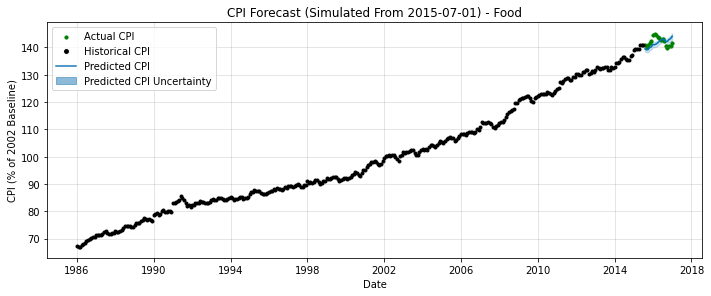

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.855
mae         1.890
mape        0.013
mse         4.722
rmse        2.173
dtype: float64
Initial log joint probability = -2.31054
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1631.26    0.00060919       804.612           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1645.18   0.000662073        452.81           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1660.76   0.000513567       179.924           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1663.39   0.000602128       354.493      0.7734      0.7734      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1665.05    0.00030002       699

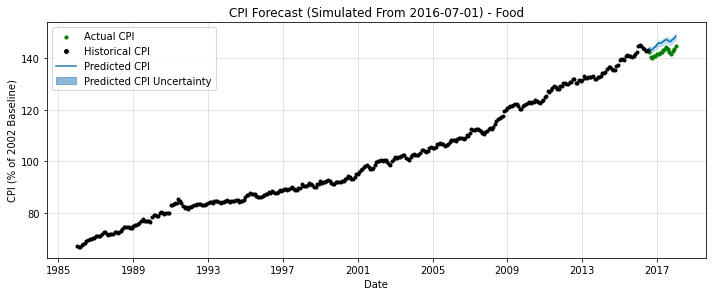

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.380
mae          3.514
mape         0.025
mse         12.844
rmse         3.584
dtype: float64
Initial log joint probability = -2.2499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1660.83    0.00038075       1792.15      0.1638      0.1638      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1670.14    0.00231421       843.643           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1675.1   0.000162962       119.855           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1677.52    0.00244547       185.418           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1678.74   0.000110064      

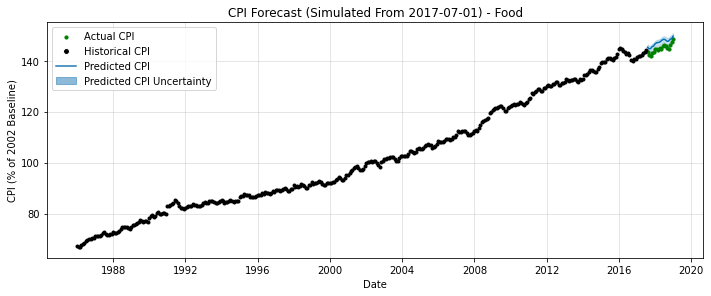

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -1.069
mae         2.337
mape        0.016
mse         5.815
rmse        2.411
dtype: float64
Initial log joint probability = -2.23278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1698.27    0.00499289       1622.48           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1712.8   0.000248786       842.654      0.5886      0.5886      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1719.23   8.10992e-05       517.464       0.275       0.275      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1721.32    0.00362525       322.315      0.9248      0.9248      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       1722.41   3.78495e-05       162

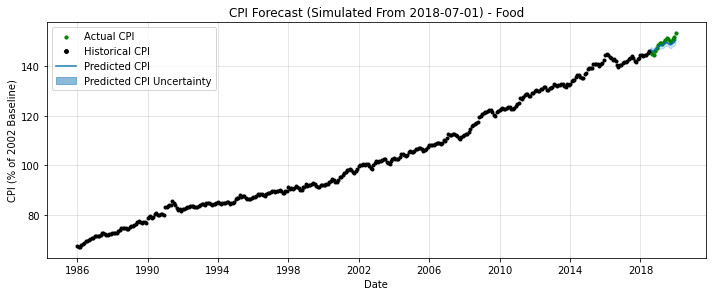

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.675
mae         1.238
mape        0.008
mse         1.916
rmse        1.384
dtype: float64
Initial log joint probability = -2.3316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1764.69    0.00045496       1875.92       0.554       0.554      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1781.81    0.00853857       1085.72           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1788.52    0.00324086       1477.66      0.2377           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1792.74    0.00823593       1433.67           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1796.81    0.00352996       1469

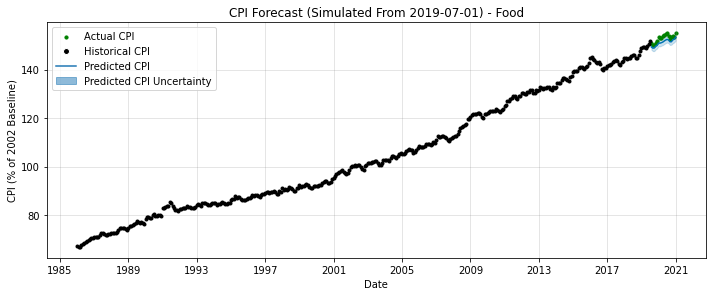

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.628
mae         1.879
mape        0.012
mse         3.815
rmse        1.953
dtype: float64
Initial log joint probability = -2.3579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1810.17    0.00369287       529.141           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1835.45    0.00411581       1423.91           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.54     0.0045486       896.644           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1842.16   0.000906037       486.546      0.6577      0.6577      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     490       1843.96   5.68449e-06       81.9

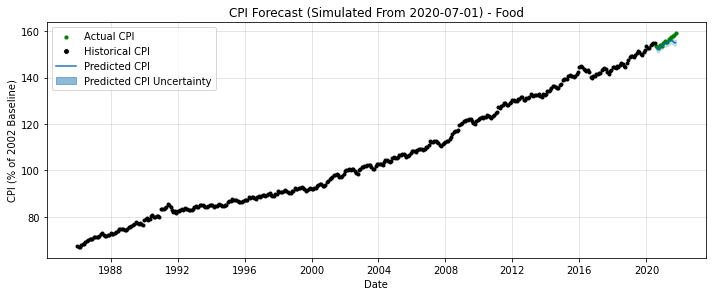

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.254
mae         1.309
mape        0.008
mse         2.899
rmse        1.703
dtype: float64
Initial log joint probability = -2.90205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1130.46    0.00908522       813.118           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1133.9    0.00218357        122.57           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       1134.29   0.000235973        176.57   2.849e-06       0.001      332  LS failed, Hessian reset 
     299       1134.63    0.00309583       104.711           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       1134.98   0.000113733       124.379   7.748e-07       0.001      505  LS failed, Hessian reset 
   

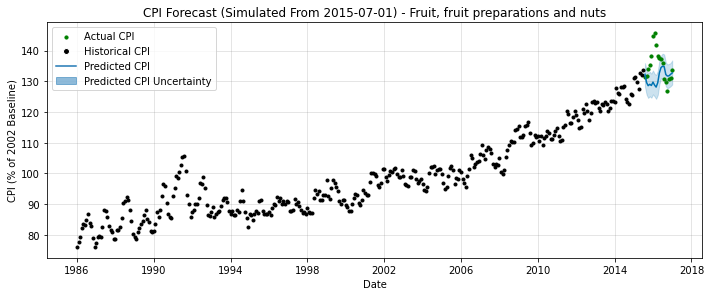

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.225
mae          5.625
mape         0.041
mse         56.756
rmse         7.534
dtype: float64
Initial log joint probability = -2.79024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1175.07     0.0019378       522.517      0.4619      0.8874      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1179.06    0.00121975        283.83           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1180.59   9.41704e-05       78.0939      0.2417      0.7887      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342        1180.6   3.19271e-07       68.9679   4.766e-09       0.001      477  LS failed, Hessian reset 
     345        1180.6   7.50518e-08       50.3552      0.5054      0.5054      480   
Optimization terminate

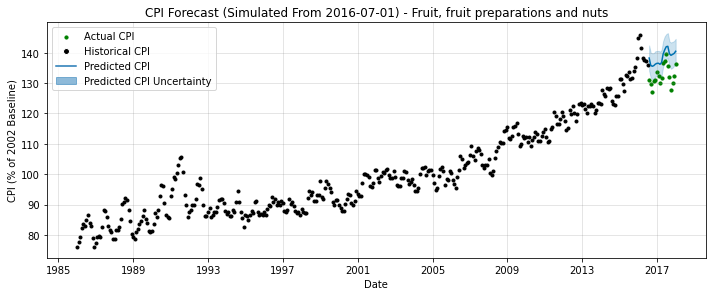

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.689
mae          5.898
mape         0.045
mse         40.430
rmse         6.358
dtype: float64
Initial log joint probability = -2.9315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1211.21   3.52554e-05       238.669     0.02774     0.02774      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1214.22    0.00297421        126.53      0.9376      0.9376      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       1214.26   0.000137341       152.299   1.178e-06       0.001      294  LS failed, Hessian reset 
     272       1214.62   1.85579e-08       62.9229     0.04161           1      392   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


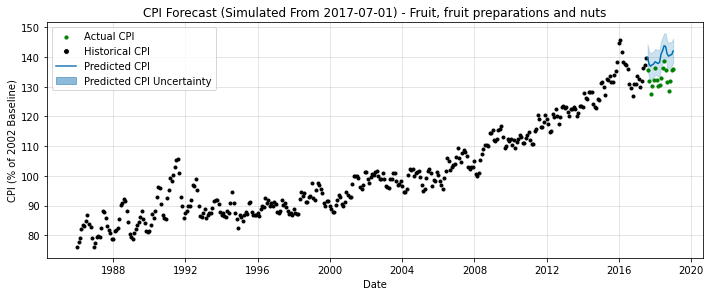

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.835
mae          6.835
mape         0.052
mse         51.329
rmse         7.164
dtype: float64
Initial log joint probability = -2.73356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1241.04   0.000224738       103.841           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1243.75   0.000338875       146.015           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1245.13    0.00505408       125.464           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1245.72    1.1856e-05       68.4749           1           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1245.89   0.000187087     

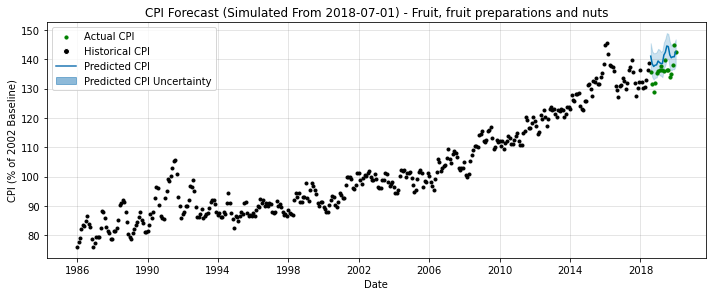

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.134
mae          4.642
mape         0.034
mse         28.186
rmse         5.309
dtype: float64
Initial log joint probability = -2.51446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1274.46   0.000366858       111.978      0.6409      0.6409      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1277.98    0.00019631       102.625     0.06936           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       1278.69   0.000129052       118.634   5.033e-07       0.001      341  LS failed, Hessian reset 
     248       1279.25    8.6172e-05       107.622   6.492e-07       0.001      404  LS failed, Hessian reset 
     299       1279.33   9.08342e-06       78.1952       0.463       0.463      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

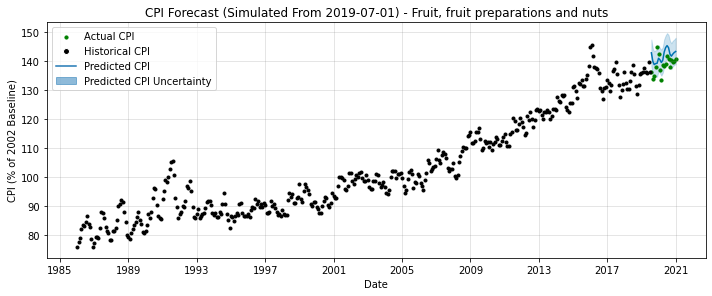

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.077
mae          3.821
mape         0.028
mse         17.577
rmse         4.193
dtype: float64
Initial log joint probability = -2.69346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1309.31    0.00129077       108.485           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       1313.48   0.000502858        198.76   5.985e-06       0.001      241  LS failed, Hessian reset 
     199        1314.3    0.00190369       123.895           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       1314.74    0.00013087       154.825   1.299e-06       0.001      350  LS failed, Hessian reset 
     299       1315.28   3.56207e-05       65.9679      0.6871      0.6871      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

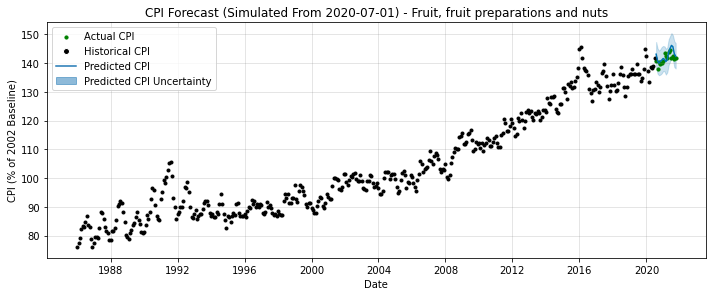

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.432
mae         1.562
mape        0.011
mse         3.815
rmse        1.953
dtype: float64
Initial log joint probability = -3.52442
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1281.14    0.00846674       978.252           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       1288.75   0.000102553       216.683   1.008e-06       0.001      260  LS failed, Hessian reset 
     199       1290.14     0.0011805       261.725           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1294.88   0.000240028       131.475      0.3849      0.3849      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       1295.09   5.66502e-05       137.907   6.922e-07       0.001      450  LS failed, Hessian reset 
   

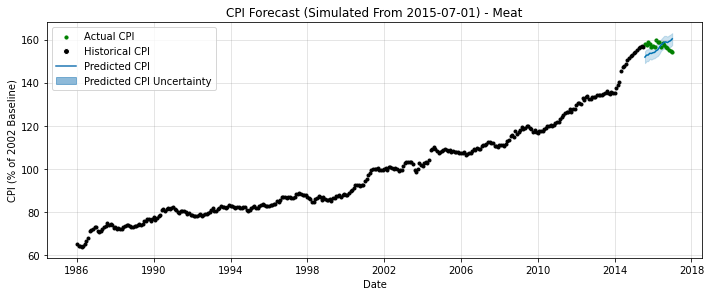

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -5.664
mae          3.494
mape         0.022
mse         15.126
rmse         3.889
dtype: float64
Initial log joint probability = -3.3323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1339.43     0.0109472       616.533           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1358.5    0.00280763       992.623           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1364.67    0.00229806       303.942      0.3881      0.3881      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1367.89     0.0101894        531.44       0.944       0.944      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1370.62   0.000139349      

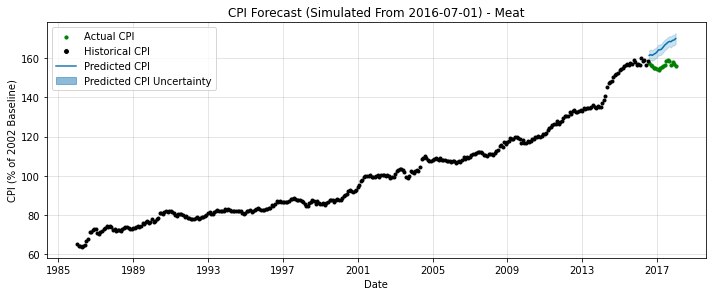

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -41.068
mae          9.089
mape         0.058
mse         88.773
rmse         9.422
dtype: float64
Initial log joint probability = -3.07077
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1360.87    0.00708816       590.212           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1365.41   0.000656026       206.865           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       1365.82   7.37159e-05       69.0093   8.905e-07       0.001      301  LS failed, Hessian reset 
     299        1367.4   7.89015e-05        199.99   2.832e-07       0.001      440  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       1368.46   0.000151045       229.132   2.244e-06       0.001      590  

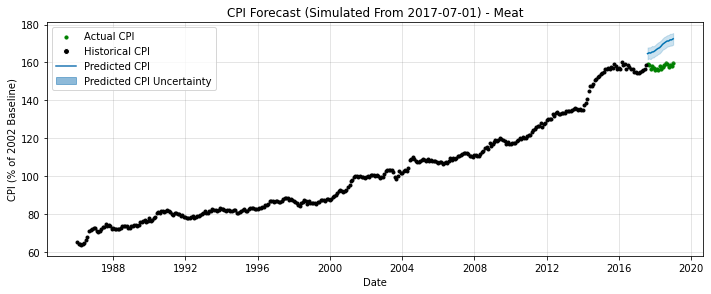

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -79.104
mae          10.513
mape          0.067
mse         116.163
rmse         10.778
dtype: float64
Initial log joint probability = -2.88274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1358.68    0.00140912       448.204      0.5987      0.5987      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       1363.22    0.00010526       177.576   6.224e-07       0.001      237  LS failed, Hessian reset 
     199       1363.98   8.17565e-05       252.737       0.624       0.624      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       1364.52   5.23732e-05       94.4293   8.309e-07       0.001      375  LS failed, Hessian reset 
     276       1364.85   0.000141326       171.595   1.557e-06       0.001      468  LS failed, Hessian reset 
     299       1364.91   1.89075e-05       56.3358           

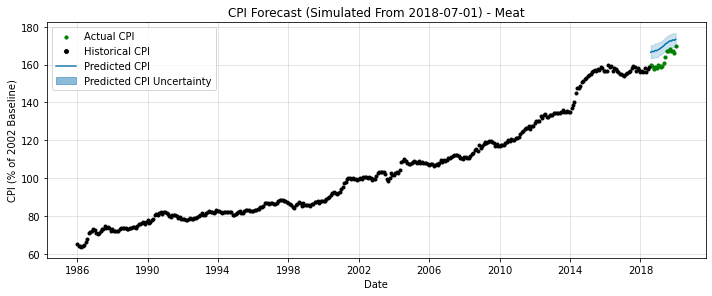

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.278
mae          7.173
mape         0.044
mse         55.780
rmse         7.469
dtype: float64
Initial log joint probability = -3.2237
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1395.08   0.000956108       92.6544           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1399.12   0.000572354       86.6912           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1400.43    0.00298247       241.705      0.2864           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       1400.45    7.8995e-05       115.184   1.329e-06       0.001      407  LS failed, Hessian reset 
     326       1400.59   3.89605e-05       86.7212   4.205e-07       0.001      476  LS failed, Hessian reset 

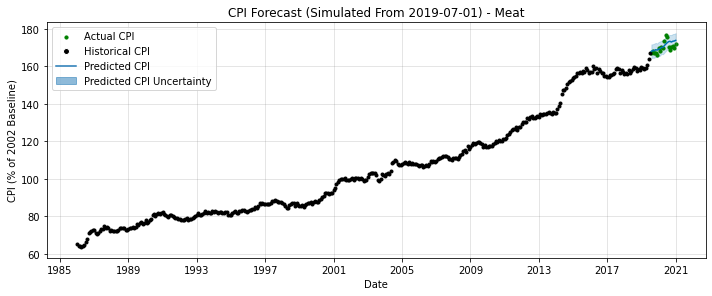

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.183
mae         2.118
mape        0.012
mse         6.501
rmse        2.550
dtype: float64
Initial log joint probability = -3.5247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1470.37    0.00446955       308.063           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       1476.99   0.000208641       123.663   2.354e-06       0.001      278  LS failed, Hessian reset 
     199       1477.06   7.21627e-05       93.5521      0.7573      0.7573      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1478.69     5.176e-05       118.119   2.192e-07       0.001      425  LS failed, Hessian reset 
     299       1479.51   0.000643777        124.74           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

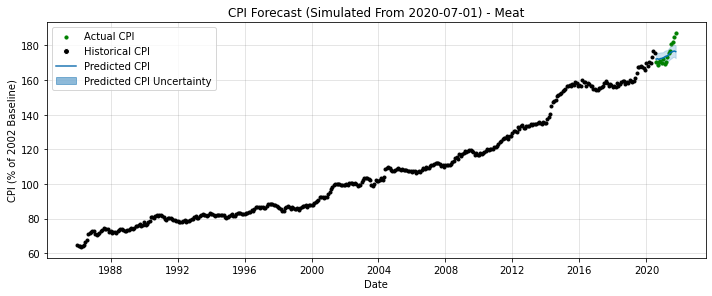

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.446
mae          3.352
mape         0.019
mse         19.217
rmse         4.384
dtype: float64
Initial log joint probability = -2.2565
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1320.86     0.0095106       805.715           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1348.51     0.0223572       1375.86           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1360.3   0.000913815       203.147           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1368.34   0.000958026       190.442           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1370.68   5.79625e-05      

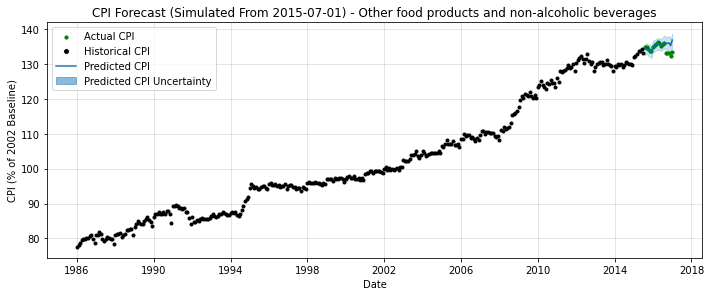

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.772
mae         1.065
mape        0.008
mse         2.539
rmse        1.593
dtype: float64
Initial log joint probability = -2.26887
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1404.38     0.0366851       1554.75           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1443.95    0.00047118       315.988           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1451.48    0.00209599       420.235          10           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1460.68    0.00763657        1187.8           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     419       1461.46   1.21928e-05       90.

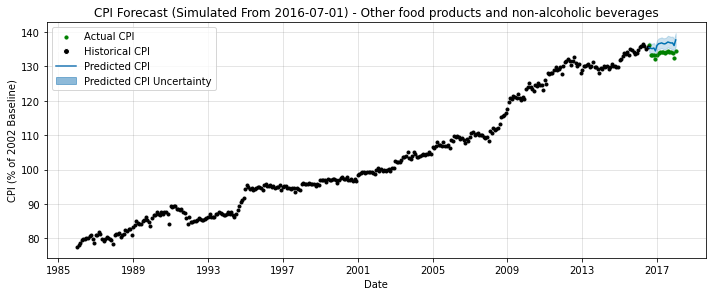

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -8.132
mae         2.467
mape        0.018
mse         6.469
rmse        2.543
dtype: float64
Initial log joint probability = -2.18937
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1463.86     0.0986947       3586.27           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1500.66     0.0173596       996.327           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1515.43   0.000275803       303.927      0.2995      0.2995      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1520.58    0.00167729       427.409           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1525.27    0.00410836       950

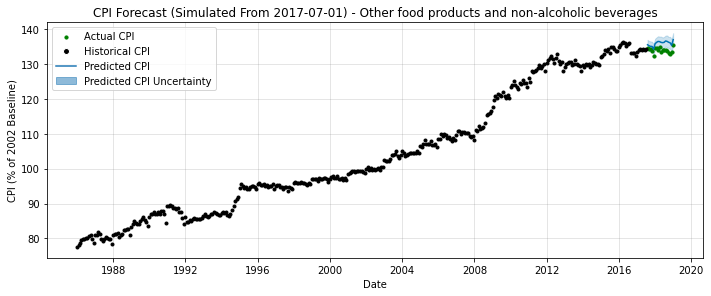

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -7.894
mae         1.956
mape        0.015
mse         4.349
rmse        2.086
dtype: float64
Initial log joint probability = -2.17846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1508.19   0.000884126       570.709           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1543.09     0.0024153       347.248           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1556.01    0.00622697       786.771      0.9526      0.9526      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1575.62   0.000196127       89.1362           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1580.22    0.00124199       489

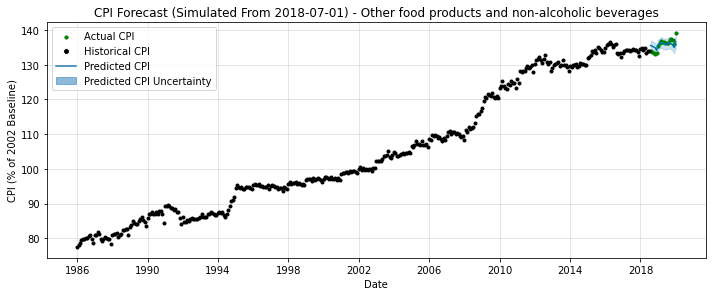

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.468
mae         0.947
mape        0.007
mse         1.401
rmse        1.184
dtype: float64
Initial log joint probability = -2.17779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1543.27     0.0186341       2512.41           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1590.41     0.0012748        1474.4      0.3735      0.3735      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1614.16    0.00413756       1136.14       6.565      0.6565      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1623.75    0.00274239       549.207           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495       1626.32   9.08373e-06       74.

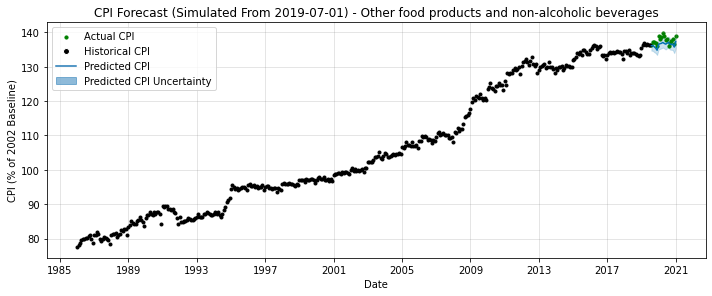

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.910
mae         1.381
mape        0.010
mse         2.349
rmse        1.532
dtype: float64
Initial log joint probability = -2.17091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1620.18     0.0363554       987.125           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1659.05     0.0172955       1079.57           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1673.66    0.00889719       1437.41           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       1674.73   3.83865e-05       253.721   1.353e-07       0.001      411  LS failed, Hessian reset 
     399       1678.66    0.00453783       499.808           1           1      490   
    Iter      log prob     

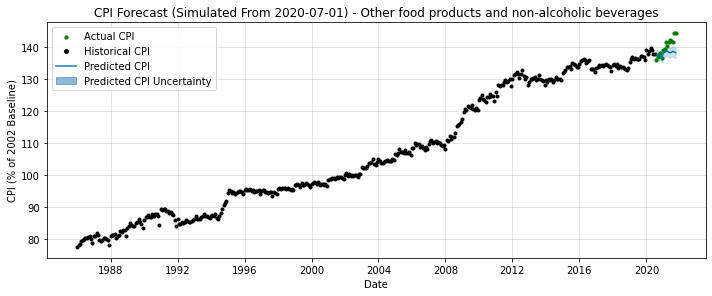

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.313
mae         2.344
mape        0.017
mse         9.011
rmse        3.002
dtype: float64
Initial log joint probability = -3.86358
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        961.99   0.000605372       104.677           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       962.854    0.00088153        110.98   5.418e-06       0.001      226  LS failed, Hessian reset 
     189       963.319   6.30978e-05       56.2371   1.026e-06       0.001      322  LS failed, Hessian reset 
     199       963.321   9.12404e-07       68.9006      0.1974           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       963.324   3.48066e-05         69.32   4.806e-07       0.001      388  LS failed, Hessian reset 
     299       963.406   0.000328433       60.1024      0.4602         

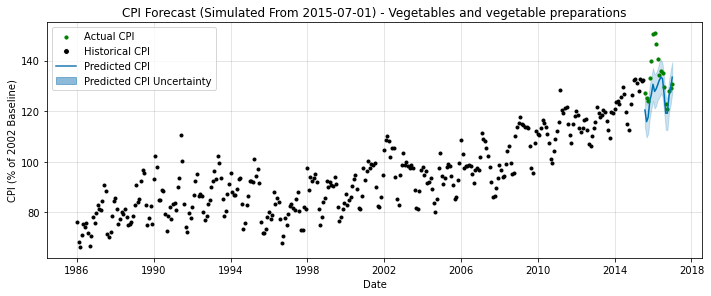

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     -0.293
mae           7.543
mape          0.054
mse         101.780
rmse         10.089
dtype: float64
Initial log joint probability = -3.5538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1025.57    0.00301889       309.536      0.7301      0.7301      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1026.85   0.000121738        58.248     0.05417           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1026.99   3.90885e-05       55.2528      0.3327      0.3327      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       1027.13   0.000757912       225.913   7.953e-06       0.001      471  LS failed, Hessian reset 
     399       1027.39   7.75527e-06       47.3549      0.9166     0.09166      568   
    Iter      log 

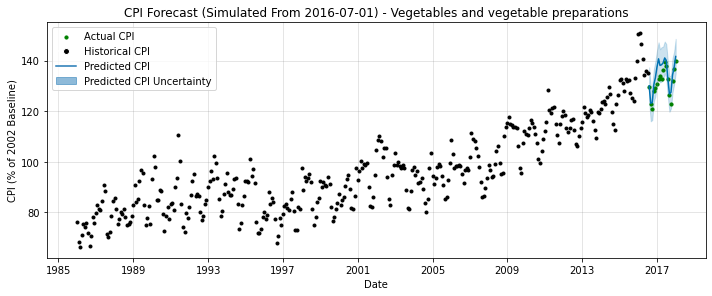

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.581
mae          2.833
mape         0.022
mse         12.625
rmse         3.553
dtype: float64
Initial log joint probability = -3.6296
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1062.03   0.000397828       57.6339      0.4145      0.4145      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       1063.93    0.00018763       104.996   2.977e-06       0.001      255  LS failed, Hessian reset 
     199       1063.97   7.24013e-07       55.6308     0.05579           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       1063.97   1.50578e-06       53.1179   2.594e-08       0.001      361  LS failed, Hessian reset 
     272       1063.99   0.000203053       96.6828   1.911e-06       0.001      466  LS failed, Hessian reset 
     299       1063.99    7.3672e-06       57.9195     0.02947     

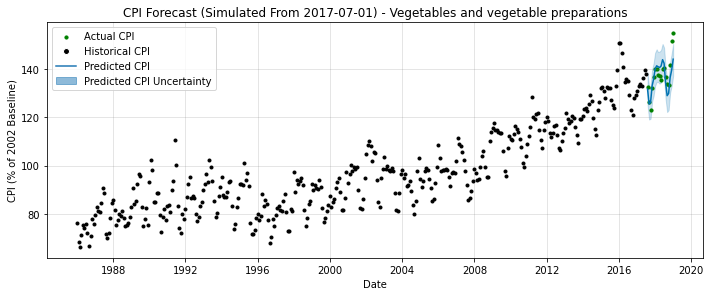

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.566
mae          3.646
mape         0.026
mse         23.725
rmse         4.871
dtype: float64
Initial log joint probability = -3.70272
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1099.87    0.00659442       194.858           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       1101.69   0.000190617       83.3427   1.085e-06       0.001      286  LS failed, Hessian reset 
     199        1101.9   0.000223963       67.4606       0.651       0.651      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1101.99   0.000153795       109.356   1.519e-06       0.001      380  LS failed, Hessian reset 
     253          1102   8.84542e-07        51.118   1.618e-08       0.001      465  LS failed, Hessian reset 
     299       1102.07   2.53929e-05       63.2911       0.604    

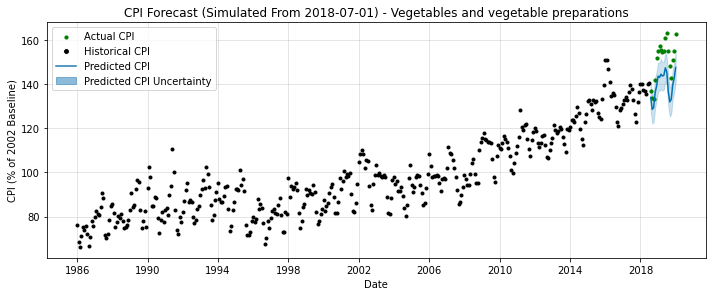

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     -0.764
mae          11.238
mape          0.073
mse         145.370
rmse         12.057
dtype: float64
Initial log joint probability = -6.20023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1155.83     0.0010113       82.9396      0.8529      0.8529      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1157.37   0.000334542       46.0325      0.7102      0.7102      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1157.67    0.00025349        130.07    3.85e-06       0.001      328  LS failed, Hessian reset 
     247       1157.76   7.58586e-05       73.2453   1.155e-06       0.001      392  LS failed, Hessian reset 
     281       1157.79   0.000171823       104.168   2.397e-06       0.001      479  LS failed, Hessian reset 
     299       1157.79   5.66817e-06       68.1556      0.289

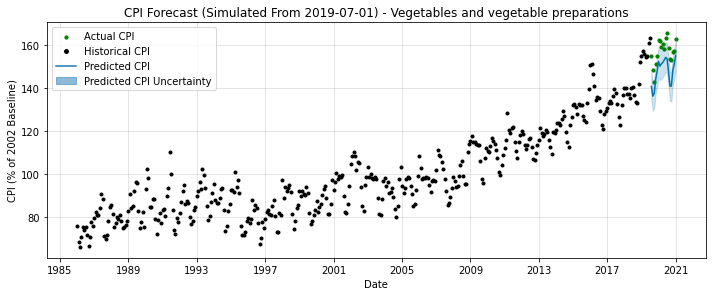

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.962
mae          9.284
mape         0.059
mse         93.185
rmse         9.653
dtype: float64
Initial log joint probability = -6.06447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1189.48    0.00155953       109.152      0.7977      0.7977      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       1192.33   0.000152747       93.4193   1.031e-06       0.001      246  LS failed, Hessian reset 
     199       1192.75   0.000825088       85.2239      0.8425      0.8425      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1193.27   7.64145e-06       69.0735      0.9294      0.9294      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       1193.27   5.85814e-06       64.8137   9.435e-08       0.001      450  LS failed, Hessian reset

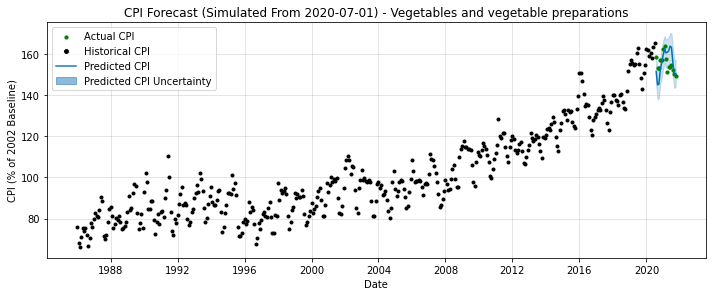

r2_score    -1.249
mae          5.115
mape         0.033
mse         37.191
rmse         6.098
dtype: float64


In [26]:
all_valid_metrics = {}
all_forecasts = {}

for food_category in foodprice_categories:

    annual_valid_metrics = {}
    annual_forecasts = {}

    for date in report_sim_dates:  

        train_dates = sim_train_dates[date]
        valid_dates = sim_valid_dates[date]

        model, valid_forecast, valid_metrics = fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates)
        valid_actual = get_prophet_df(foodprice_df, food_category, valid_dates) 

        plot_valid_forecast(model, food_category, date, valid_forecast, valid_actual)
        valid_metrics_series = pd.Series(valid_metrics)
        print(valid_metrics_series)

        annual_valid_metrics[date] = pd.DataFrame(valid_metrics_series).mean(axis=1)
        annual_forecasts[date] = valid_forecast.yhat

    all_valid_metrics[food_category] = annual_valid_metrics
    all_forecasts[food_category] = annual_forecasts

### Collect Validation Metrics and Save to File

In [27]:
mean_valid_metrics = {}
for food_category, valid_scores in all_valid_metrics.items():
    mean_valid_metrics[food_category] = pd.DataFrame(valid_scores).mean(axis=1)

mean_valid_metrics_df = pd.DataFrame(mean_valid_metrics).T
mean_valid_metrics_df.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_valid_metrics_df

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-13.219,4.133,0.027,26.205,4.522
Dairy products and eggs,-10.412,4.281,0.031,24.637,4.590
"Fish, seafood and other marine products",-1.737,2.711,0.020,10.496,3.073
Food purchased from restaurants,-0.368,1.880,0.012,5.373,2.005
Food,-1.334,2.028,0.014,5.335,2.201
"Fruit, fruit preparations and nuts",-1.899,4.731,0.035,33.015,5.419
Meat,-21.247,5.956,0.037,50.260,6.415
Other food products and non-alcoholic beverages,-2.925,1.693,0.012,4.353,1.990
Vegetables and vegetable preparations,-0.520,6.610,0.045,68.979,7.720


## Save Validation Forecasts to File (For Ensembling)

In [28]:
date_forecasts = {}
for date in report_sim_dates:
    valid_dates = sim_valid_dates[date]
    food_forecasts = {}
    for food_category in foodprice_categories:
        food_forecasts[food_category] = all_forecasts[food_category][date]
    date_forecasts[date] = pd.DataFrame(food_forecasts)
    date_forecasts[date] = date_forecasts[date].set_index(pd.DatetimeIndex(valid_dates))
    date_forecasts[date].to_csv(f"{output_path}/forecasts_{date}.csv")